### Lib

In [ ]:
import os
import cv2
import pandas as pd
import os
import shutil      #For file operations
import numpy as np
from glob import glob  #For Sorting
import pandas as pd
import random
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR, SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm
import joblib


: 

### Filtering Main Dataset

In [ ]:
src_folder = "Dataset-C"
green_lane_folder = "filtered_with_green_lane"
no_green_lane_folder = "filtered_without_green_lane"
centered_car_folder = "filtered_centered"
offcenter_car_folder = "filtered_offcenter_car"
corrupt_folder = "filtered_corrupt_images"

for folder in [green_lane_folder, no_green_lane_folder, centered_car_folder, offcenter_car_folder, corrupt_folder]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)
lower_green = np.array([40, 40, 40])
upper_green = np.array([90, 255, 255])

# Centering threshold (image center ± 20%)
center_threshold = 0.2
stats = {
    "with_green_lane": 0,
    "without_green_lane": 0,
    "centered_car": 0,
    "offcenter_car": 0,
    "corrupt": 0
}

image_paths = sorted(glob(os.path.join(src_folder, "*.png")))
for i, image_path in enumerate(image_paths):
    fname = os.path.basename(image_path)
    img = cv2.imread(image_path)

    if img is None:
        shutil.copy(image_path, os.path.join(corrupt_folder, fname))
        stats["corrupt"] += 1
        continue

    # ---- ONLY USE BOTTOM HALF FOR LANE DETECTION ----
    h, w, _ = img.shape
    bottom_half = img[h//2:, :]
    hsv = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_green, upper_green)
    green_pixels = cv2.countNonZero(mask)

    if green_pixels > 100:
        shutil.copy(image_path, os.path.join(green_lane_folder, fname))
        stats["with_green_lane"] += 1

        coords = np.column_stack(np.where(mask > 0))
        if len(coords) > 0:
            x_coords = coords[:, 1]
            mean_x = np.mean(x_coords)
            center_x = bottom_half.shape[1] / 2
            if abs(mean_x - center_x) <= center_x * center_threshold:
                shutil.copy(image_path, os.path.join(centered_car_folder, fname))
                stats["centered_car"] += 1
            else:
                shutil.copy(image_path, os.path.join(offcenter_car_folder, fname))
                stats["offcenter_car"] += 1
    else:
        shutil.copy(image_path, os.path.join(no_green_lane_folder, fname))
        stats["without_green_lane"] += 1

    if i % 100 == 0:
        print(f"Processed {i} images...")
        print(f"  - Green: {stats['with_green_lane']}, No Green: {stats['without_green_lane']}, Centered: {stats['centered_car']}, Offcenter: {stats['offcenter_car']}, Corrupt: {stats['corrupt']}")

folders = {
    "with_green_lane": green_lane_folder,
    "without_green_lane": no_green_lane_folder,
    "centered_car": centered_car_folder,
    "offcenter_car": offcenter_car_folder,
    "corrupt": corrupt_folder
}
# Count
final_counts = {k: len([f for f in os.listdir(v) if f.lower().endswith('.png')]) for k, v in folders.items()}
df_final_stats = pd.DataFrame([final_counts])
print(df_final_stats)
print("\n Final Split Summary:")
print(f" With green line         : {final_counts['with_green_lane']}")
print(f" Without green line      : {final_counts['without_green_lane']}")
print(f" Centered green line     : {final_counts['centered_car']}")
print(f" Off-center green line   : {final_counts['offcenter_car']}")
print(f" Corrupted images        : {final_counts['corrupt']}")
print("\n Process completed successfully!")

   with_green_lane  without_green_lane  centered_car  offcenter_car  corrupt
0                0                   0             0              0        0

 Final Split Summary:
 With green line         : 0
 Without green line      : 0
 Centered green line     : 0
 Off-center green line   : 0
 Corrupted images        : 0

 Process completed successfully!


### Detect && Classify

In [18]:
def detect_green_lane_angle_and_center(image):
    h, w, _ = image.shape
    bottom_half = image[h//2:, :]
    hsv = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None, None
    largest = max(contours, key=cv2.contourArea)
    [vx, vy, x, y] = cv2.fitLine(largest, cv2.DIST_L2, 0, 0.01, 0.01)
    angle = -np.degrees(np.arctan2(vx, vy))                          
    green_coords = np.column_stack(np.where(mask > 0))
    if green_coords.size == 0:
        lane_center = None
    else:
        lane_center = int(np.mean(green_coords[:, 1]))
    img_width = bottom_half.shape[1]
    return angle, lane_center, img_width

def classify_lane_position(lane_center, img_width):
    if lane_center is None:
        return 0.0
    center_x = img_width // 2
    if lane_center < center_x - 10:
        return -1.0
    elif lane_center > center_x + 10:
        return 1.0
    else:
        return 0.0

### Filtered_DataSet Preperation

In [19]:
folder = 'filtered_centered'
images = [f for f in os.listdir(folder) if f.lower().endswith('.png')]
images.sort()
data = []
for fname in images:
    img = cv2.imread(os.path.join(folder, fname))
    if img is None:
        continue
    angle, lane_center, img_width = detect_green_lane_angle_and_center(img) 
    label = classify_lane_position(lane_center, img_width) if (lane_center is not None and img_width is not None) else 0.0
    if angle is not None:
        data.append({'frame': fname, 'slope': float(angle), 'label': float(label)})

df = pd.DataFrame(data)[['frame', 'slope', 'label']]
df.to_csv('lane_svm_full.csv', index=False, sep=';')
print("CSV saved: lane_svm_full.csv")

C:\Users\Mohamed Abdo\AppData\Local\Temp\ipykernel_14988\2620648338.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.append({'frame': fname, 'slope': float(angle), 'label': float(label)})


CSV saved: lane_svm_full.csv


### Split Train && Test 

In [20]:
df = pd.read_csv('lane_svm_full.csv', sep=';')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df.to_csv('lane_svm_train.csv', index=False, sep=';')
test_df.to_csv('lane_svm_test.csv', index=False, sep=';')
print("Train and test CSVs saved.")

Train and test CSVs saved.


### Train && Export SVM Model
### SVM: SVC (for classes) && SVR (for real values)

In [ ]:
train_df = pd.read_csv('lane_svm_train.csv', sep=';')

if 'frame,slope,label' in train_df.columns:
    train_df[['frame', 'slope', 'label']] = train_df['frame,slope,label'].str.split(',', expand=True)
    train_df = train_df.drop(columns=['frame,slope,label'])

train_df['slope'] = train_df['slope'].astype(float)
train_df['label'] = train_df['label'].astype(float)

# Remove outliers from training data
mean, std = train_df['slope'].mean(), train_df['slope'].std()
train_df = train_df[(train_df['slope'] > mean - 3*std) & (train_df['slope'] < mean + 3*std)]

X_train = train_df[['slope']].values
y_train = train_df['label'].values

# === Train and save linear SVM (classifier) ===
clf_linear = make_pipeline(StandardScaler(), SVC(kernel='linear', class_weight='balanced'))
clf_linear.fit(X_train, y_train)
joblib.dump(clf_linear, "svm_model.joblib")
print("SVM classifier model saved as svm_model.joblib")

#

# === Train and save linear SVR (regressor) ===
svr_linear = make_pipeline(StandardScaler(), SVR(kernel='linear'))
svr_linear.fit(X_train, y_train)
joblib.dump(svr_linear, "svr_model.joblib")
print("SVR regressor model saved as svr_model.joblib")

SVM classifier model saved as svm_model.joblib
SVR regressor model saved as svr_model.joblib


### Evaluate


=== Linear SVM Classification Report ===
              precision    recall  f1-score   support

        -1.0      0.582     0.538     0.559       212
         0.0      0.069     0.125     0.089        16
         1.0      0.568     0.576     0.572       217

    accuracy                          0.542       445
   macro avg      0.406     0.413     0.407       445
weighted avg      0.557     0.542     0.548       445

Linear SVM Test Accuracy: 54.16%


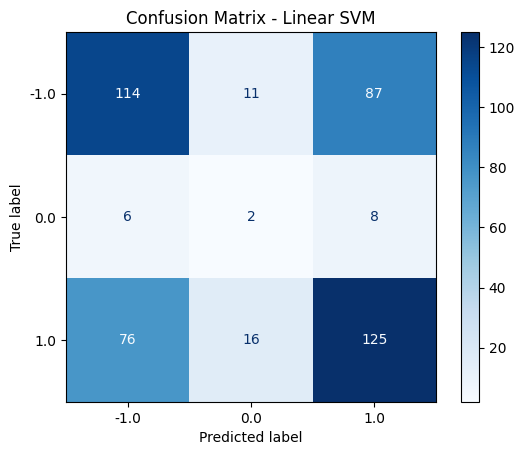


=== SVR Regression Evaluation ===
Mean squared error: 1.0721
Mean absolute error: 0.8315
R^2 score: -0.11

Sample predictions (Test Set):
Slope: -12.293 | True: 1.0 | SVM: 1.0 | SVR: 1.006
Slope: -11.251 | True: 1.0 | SVM: 1.0 | SVR: 1.019
Slope: -75.983 | True: -1.0 | SVM: 1.0 | SVR: 0.203
Slope: -92.867 | True: -1.0 | SVM: -1.0 | SVR: -0.010
Slope: -92.239 | True: 1.0 | SVM: 0.0 | SVR: -0.002


In [ ]:
test_df = pd.read_csv('lane_svm_test.csv', sep=';')

if 'frame,slope,label' in test_df.columns:
    test_df[['frame', 'slope', 'label']] = test_df['frame,slope,label'].str.split(',', expand=True)
    test_df = test_df.drop(columns=['frame,slope,label'])

test_df['slope'] = test_df['slope'].astype(float)
test_df['label'] = test_df['label'].astype(float)

X_test = test_df[['slope']].values
y_test = test_df['label'].values

# === Load SVM classifier ===
clf_linear = joblib.load("svm_model.joblib")
y_pred_linear = clf_linear.predict(X_test)

print("\n=== Linear SVM Classification Report ===")
print(classification_report(y_test, y_pred_linear, digits=3))
print(f"Linear SVM Test Accuracy: {accuracy_score(y_test, y_pred_linear):.2%}")

cm = confusion_matrix(y_test, y_pred_linear)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_linear.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Linear SVM")
plt.show()

# # === Load SVR regressor ===
# svr_linear = joblib.load("svr_model.joblib")
# y_pred_reg = svr_linear.predict(X_test)

# print("\n=== SVR Regression Evaluation ===")
# print(f"Mean squared error: {mean_squared_error(y_test, y_pred_reg):.4f}")
# print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred_reg):.4f}")
# print(f"R^2 score: {r2_score(y_test, y_pred_reg):.2f}")

# print("\nSample predictions (Test Set):")
# for i in range(min(5, len(X_test))):
#     print(f"Slope: {X_test[i][0]:.3f} | True: {y_test[i]} | SVM: {y_pred_linear[i]} | SVR: {y_pred_reg[i]:.3f}")

## Test to visualize the lanes only

In [ ]:
import os

def detect_green_lane_angle_and_center(image):
    h, w, _ = image.shape
    bottom_half = image[h//2:, :]
    hsv = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, mask, bottom_half, None
    largest = max(contours, key=cv2.contourArea)
    [vx, vy, x, y] = cv2.fitLine(largest, cv2.DIST_L2, 0, 0.01, 0.01)
    angle = -np.degrees(np.arctan2(vx, vy))

    vis_img = bottom_half.copy()
    lefty = int((-x * vy / vx) + y)
    righty = int(((vis_img.shape[1] - x) * vy / vx) + y)
    cv2.line(vis_img, (vis_img.shape[1] - 1, righty), (0, lefty), (0, 0, 255), 3)
    # Draw center vertical blue line
    center_x = vis_img.shape[1] // 2
    cv2.line(vis_img, (center_x, 0), (center_x, vis_img.shape[0]-1), (255, 0, 0), 2)
    # Find green lane center (mean x of green pixels)
    green_coords = np.column_stack(np.where(mask > 0))
    if green_coords.size == 0:
        lane_center = None
    else:
        # green_coords[:,1] is the x axis
        lane_center = int(np.mean(green_coords[:,1]))
    return angle, mask, vis_img, lane_center

def classify_lane_position(lane_center, img_width):
    if lane_center is None:
        return 0  # default to straight if not found
    center_x = img_width // 2
    if lane_center < center_x - 10:  # 10 px margin
        return -1  # left
    elif lane_center > center_x + 10:
        return 1   # right
    else:
        return 0   # straight
# float:  to the max array , try , ideas for how many lefts, speed, 0.3 , paraments to addapt , 
if __name__ == "__main__":
    folder = 'filtered_centered'
    images = [f for f in os.listdir(folder) if f.lower().endswith('.png')]
    if not images:
        print("No images found.")
        exit()

    # Build dataset for SVM (X: lane_center offset, y: class)
    X = []
    y = []
    for fname in images[:50]:
        img = cv2.imread(os.path.join(folder, fname))
        if img is None:
            continue
        angle, mask, vis_img, lane_center = detect_green_lane_angle_and_center(img)
        img_width = vis_img.shape[1]
        label = classify_lane_position(lane_center, img_width)
        if lane_center is not None:
            X.append([lane_center - img_width//2])
            y.append(label)

    # Train SVM for 3 classes
    if len(set(y)) < 2:
        print("Not enough classes for SVM training. Try more varied images.")
        exit()
    clf = svm.SVC(kernel='linear')
    clf.fit(X, y)

    # Test on a random image from the dataset
    fname = random.choice(images)
    img = cv2.imread(os.path.join(folder, fname))
    angle, mask, vis_img, lane_center = detect_green_lane_angle_and_center(img)
    center_x = vis_img.shape[1] // 2
    predicted_class = clf.predict([[lane_center - center_x]])[0] if lane_center is not None else 0
    print(f"Randomly selected: {fname}")
   
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap='gray')
    plt.title('Green Mask (half)')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    if lane_center is not None:
        plt.scatter([lane_center], [vis_img.shape[0]//2])
        plt.legend()
    plt.title(f'Labeling\nSVM class: {predicted_class}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

: 

## Check with Prof:
SMOTE: Oversampling means artificially increasing the number of samples in the minority class(es) to balance the dataset. This helps machine learning models (like SVM) not ignore rare classes, which improves classification accuracy for those classes.

### In CARLA:
- carla_lane_following_control.py logic to load the model,
- Get the predicted class (-1.0, 0.0, 1.0),
- Convert it into a steering value,
- Apply it to vehicle.
- Run: python carla_lane_following_control.py
- Timming: 0.05 seconds per frame (20 Hz) >> 20 frames per second (default)

In [ ]:
model = joblib.load("lane_svm_model.joblib")
print(" SVM model loaded.")

def detect_green_lane_angle(image):
    h, w, _ = image.shape
    bottom_half = image[h//2:, :]
    hsv = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest = max(contours, key=cv2.contourArea)
    [vx, vy, x, y] = cv2.fitLine(largest, cv2.DIST_L2, 0, 0.01, 0.01)
    angle = -np.degrees(np.arctan2(vx, vy))
    return angle


def get_steering_command(image, model, steering_gain=0.3):
    angle = detect_green_lane_angle(image)
    if angle is None:
        return 0.0   # Fallback: drive straight
    pred = model.predict([[angle]])[0]
    steering = float(pred) * steering_gain
    return steering

# #=== 4. Carla Integration ===
# def main():
#     client = carla.Client("localhost", 2000)
#     client.set_timeout(10.0)
#     world = client.get_world()

#     # Find your vehicle (first spawned vehicle)
#     vehicle = None
#     for actor in world.get_actors():
#         if actor.type_id.startswith('vehicle'):
#             vehicle = actor
#             break
#     if vehicle is None:
#         print(" No vehicle found!")
#         return

#     # Attach an RGB camera sensor
#     blueprint_library = world.get_blueprint_library()
#     camera_bp = blueprint_library.find('sensor.camera.rgb')
#     camera_bp.set_attribute('image_size_x', '800')
#     camera_bp.set_attribute('image_size_y', '600')
#     camera_bp.set_attribute('fov', '90')
#     spawn_point = carla.Transform(carla.Location(x=1.5, z=2.4))
#     camera = world.spawn_actor(camera_bp, spawn_point, attach_to=vehicle)

#     # Data structure to retrieve the latest image frame
#     image_data = {'array': None}

#     def process_image(image):
#         array = np.frombuffer(image.raw_data, dtype=np.uint8)
#         array = array.reshape((image.height, image.width, 4))[:, :, :3]  # BGRA -> BGR
#         image_data['array'] = array

#     camera.listen(process_image)

#     print("Lane following started. Press Ctrl+C to quit.")
#     try:
#         while True:
#             if image_data['array'] is not None:
#                 img = image_data['array']
#                 steering_cmd = get_steering_command(img, model)
#                 control = carla.VehicleControl()
#                 control.throttle = 0.45  # Tune as needed
#                 control.steer = steering_cmd
#                 control.brake = 0.0
#                 vehicle.apply_control(control)
#                 print(f"Steering: {steering_cmd:.2f}")
#             time.sleep(0.05)
#     except KeyboardInterrupt:
#         print("Stopped by user.")
#     finally:
#         camera.stop()
#         camera.destroy()

# if __name__ == '__main__':
#     main()

In [ ]:
def predict_steering(img):
    models = ["svm", "svr"]
    model_files = {
        "svm": "svm_model.joblib",
        "svr": "svr_model.joblib"
    }

    if not hasattr(predict_steering, "_models"):
        predict_steering._models = {}

    model = None
    for model_type in models:
        if model_type not in predict_steering._models:
            model_path = model_files[model_type]
            if os.path.isfile(model_path):
                predict_steering._models[model_type] = joblib.load(model_path)
            else:
                predict_steering._models[model_type] = None
        if predict_steering._models[model_type] is not None:
            model = predict_steering._models[model_type]
            break

    if model is not None:
        features = extract_features(img)  # You must define extract_features for your use-case
        try:
            pred = float(model.predict(features)[0])
        except Exception:
            pred = 0.0

        if pred > 0:
            return 1
        elif pred < 0:
            return -1
        else:
            return 0

    return random.choice([-1, 0, 1])

In [ ]:
def extract_features(image):
    h, w, _ = image.shape
    bottom_half = image[h//2:, :]
    hsv = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([90, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, mask, bottom_half, None
    largest = max(contours, key=cv2.contourArea)
    [vx, vy, x, y] = cv2.fitLine(largest, cv2.DIST_L2, 0, 0.01, 0.01)
    angle = -np.degrees(np.arctan2(vx, vy))

    vis_img = bottom_half.copy()
    lefty = int((-x * vy / vx) + y)
    righty = int(((vis_img.shape[1] - x) * vy / vx) + y)
    cv2.line(vis_img, (vis_img.shape[1] - 1, righty), (0, lefty), (0, 0, 255), 3)
    # Draw center vertical blue line
    center_x = vis_img.shape[1] // 2
    cv2.line(vis_img, (center_x, 0), (center_x, vis_img.shape[0]-1), (255, 0, 0), 2)
    # Find green lane center (mean x of green pixels)
    green_coords = np.column_stack(np.where(mask > 0))
    if green_coords.size == 0:
        lane_center = None
    else:
        # green_coords[:,1] is the x axis
        lane_center = int(np.mean(green_coords[:,1]))
    return angle, mask, vis_img, lane_center